In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import seaborn as sns

## Create a model to predict the delays

#### Through this workbook,I am goin to answer below questions:
* Create a model to predict flight delays?
* How well does weather predict plane delays?

In [2]:
df_2008=pd.read_csv('2008.csv')
df_2007=pd.read_csv('2007.csv')
airport_df=pd.read_csv('airports.csv')
carrier_df=pd.read_csv('carriers.csv')
planes_df=pd.read_csv('plane-data.csv')
main_df=pd.concat([df_2008],ignore_index=True)

In [3]:
main_df['Date']=pd.to_datetime(pd.DataFrame({'year':main_df['Year'],'month':main_df['Month'],'day':main_df['DayofMonth']}))

#### Problem statement - Is there any delay in the flight or not? If there is a delay do that is Dep Delay or Arr Delay or both or None. IF so how much of departure delay and how much of arrival delay
There are two regression problems in this questions.
#### Problem Statement1 - How much is Departure Delay for this particural plane
#### Problem Statement2 - How much is Arrival Delay for this particural plane
Key parameters can be considered are:
Target parameter: DepDelay or Arr Delay (Prepare a column Total Delay)
#### Problem1 model below

In [11]:
main_df.columns
key_columns=['CRSDepTime','CRSArrTime','UniqueCarrier','AirTime','Diverted','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay',
            'LateAircraftDelay','Month','DayOfWeek','DepDelay']
key2_columns=['UniqueCarrier','Diverted','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay',
            'LateAircraftDelay','Month','DayOfWeek','DepDelay']

In [13]:
main_df_req=main_df[key2_columns].copy()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


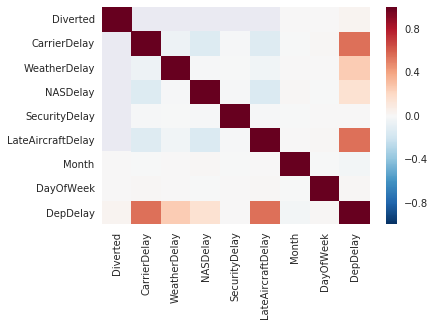

In [15]:
sns.heatmap(main_df_req.corr())

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


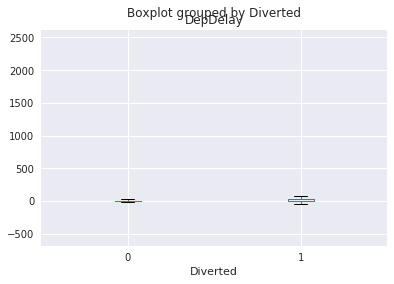

In [17]:
main_df_req.boxplot(column='DepDelay',by='Diverted')

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:450: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


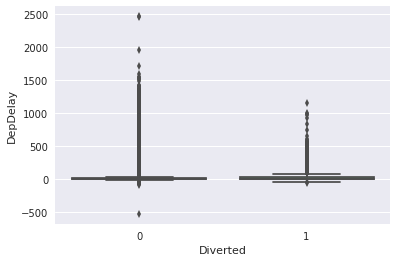

In [18]:
sns.boxplot(x='Diverted',y='DepDelay',data=main_df_req)

In [20]:
main_df_req['DepDelay'].describe(percentiles=[0.01,0.05,0.95,0.99])

count    6.873482e+06
mean     9.972570e+00
std      3.531127e+01
min     -5.340000e+02
1%      -1.200000e+01
5%      -9.000000e+00
50%     -1.000000e+00
95%      7.000000e+01
99%      1.640000e+02
max      2.467000e+03
Name: DepDelay, dtype: float64

In [24]:
main_df_req[main_df_req['DepDelay']>1000]

,UniqueCarrier,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Month,DayOfWeek,DepDelay
219451,UA,0,1032.0,0.0,0.0,0.0,49.0,1,7,1099.0
386170,MQ,1,NaN,NaN,NaN,NaN,NaN,1,5,1154.0
426476,NW,0,1120.0,0.0,26.0,0.0,0.0,1,1,1120.0
435510,NW,0,0.0,1049.0,9.0,0.0,0.0,1,7,1049.0
443080,NW,0,1017.0,0.0,0.0,0.0,0.0,1,4,1020.0
451036,NW,0,1120.0,0.0,3.0,0.0,0.0,1,7,1120.0
457771,9E,0,1017.0,0.0,0.0,0.0,0.0,1,5,1021.0
466968,9E,0,1094.0,0.0,0.0,0.0,0.0,1,4,1105.0
479580,AA,0,1036.0,0.0,21.0,0.0,0.0,1,2,1036.0
481458,AA,0,1068.0,0.0,0.0,0.0,79.0,1,7,1172.0
